# In order to compile this code, make sure you upload the 3 csv files (drag them to thefiles area) with the right names:
# 1-artists.csv
# 2-institutions.csv
# 3-relationships.csv

# Refer to the report for detailed explanation for my solutions

In [ ]:
import csv
import os
import sys
import json
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Files reading and data preprocessing**

In [ ]:
import pandas as pd

# Step 1: Load the CSV files
relationships_df = pd.read_csv('relationships.csv')
artists_df = pd.read_csv('artists.csv')
institutions_df = pd.read_csv('institutions.csv')

# Step 2: Define a function to clean the artistUrl
def clean_artist_url(url):
    # Remove the '/en/' part and strip whitespace
    return url.replace('/en/', '').strip().lower()

# Clean the artistUrl in relationships_df and artists_df
relationships_df['artistUrl'] = relationships_df['artistUrl'].apply(clean_artist_url)
artists_df['artistUrl'] = artists_df['artistUrl'].apply(clean_artist_url)

# Optional: Display cleaned data for verification
print("Cleaned Relationships DataFrame:")
print(relationships_df[['artistUrl']].head())
print("\nCleaned Artists DataFrame:")
print(artists_df[['artistUrl']].head())

# Optional: Check for unique artistUrls in both dataframes
missing_artist_urls = set(relationships_df['artistUrl']) - set(artists_df['artistUrl'])
print("\nArtist URLs in relationships but not in artists:")
print(missing_artist_urls)

# Step 3: Merge relationships_df and artists_df on artistUrl
merged_df = pd.merge(relationships_df, artists_df, on='artistUrl', how='inner')
print("\nMerged DataFrame (Relationships + Artists):")
print(merged_df.head())

# Step 4: Clean 'institution' and 'url' columns and merge with institutions_df
merged_df['institution'] = merged_df['institution'].str.strip()
institutions_df['url'] = institutions_df['url'].str.strip()
merged_institutions_df = pd.merge(merged_df, institutions_df, left_on='institution', right_on='url', how='left')
print("\nMerged DataFrame with Institutions:")
print(merged_institutions_df.head())

# Step 5: Additional cleanup of specific columns
# Clean up 'friends' column
if 'friends' in merged_institutions_df.columns:
    merged_institutions_df['friends'] = merged_institutions_df['friends'].apply(
        lambda x: ', '.join([friend.replace('/en/', '').strip() for friend in x.split(',')]) if pd.notna(x) else x
    )

# Clean up 'influenced_by' and 'influenced_on' columns
for col in ['influenced_by', 'influenced_on']:
    if col in merged_institutions_df.columns:
        merged_institutions_df[col] = merged_institutions_df[col].apply(
            lambda x: ', '.join([influence.replace('/en/', '').strip().split('/')[-1] for influence in x.split(',')]) if pd.notna(x) else x
        )

# Step 6: Rename columns
merged_institutions_df.rename(columns={
    'title_x': 'artist_name',
    'title_y': 'institution_name',
    'url': 'institution_url'
}, inplace=True)

# Step 7: Display the final processed DataFrame and save to CSV
print("Final Processed DataFrame:")
print(merged_institutions_df.head())
merged_institutions_df.to_csv('merged_final.csv', index=False)


Cleaned Relationships DataFrame:
                   artistUrl
0                    apelles
1                   wang-wei
2  ancient-egyptian-painting
3                    guanxiu
4                    han-gan

Cleaned Artists DataFrame:
                   artistUrl
0  ancient-egyptian-painting
1      ancient-greek-pottery
2     ancient-greek-painting
3                    apelles
4             fayum-portrait

Artist URLs in relationships but not in artists:
set()

Merged DataFrame (Relationships + Artists):
                   artistUrl friends               influenced_by  \
0                    apelles     NaN  /en/ancient-greek-painting   
1                   wang-wei     NaN                         NaN   
2  ancient-egyptian-painting     NaN                         NaN   
3                    guanxiu     NaN                         NaN   
4                    han-gan     NaN                         NaN   

                                       influenced_on institution  \
0            

**EDA VISUALIZATION**

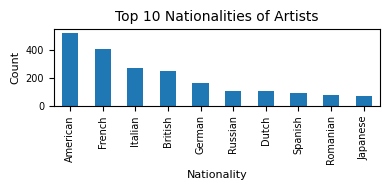

<ipython-input-20-43de46f44dca>:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


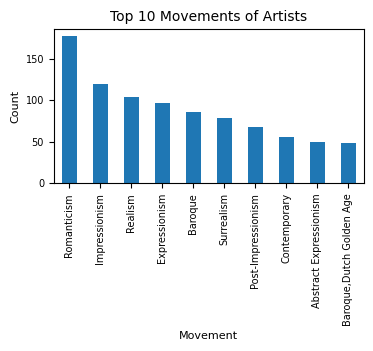

<ipython-input-20-43de46f44dca>:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


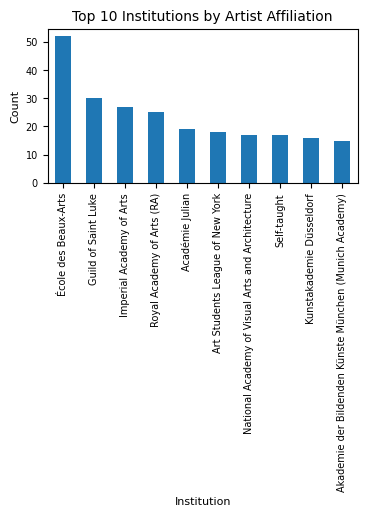

In [ ]:
# Load the cleaned and merged data
merged_df = pd.read_csv('merged_final.csv')

# Set plot style for small figures
plt.rcParams.update({'figure.figsize': (4, 2), 'axes.titlesize': 10, 'axes.labelsize': 8, 'xtick.labelsize': 7, 'ytick.labelsize': 7})

# Distribution of artists by nationality (top 10)
nationality_distribution = merged_df['nation'].value_counts().head(10)
plt.figure()
nationality_distribution.plot(kind='bar')
plt.title("Top 10 Nationalities of Artists")
plt.xlabel("Nationality")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Distribution of artists by movement (top 10, if available)
if 'movements' in merged_df.columns:
    movement_distribution = merged_df['movements'].value_counts().head(10)
    plt.figure()
    movement_distribution.plot(kind='bar')
    plt.title("Top 10 Movements of Artists")
    plt.xlabel("Movement")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Distribution of artists by institution affiliation (top 10, if available)
if 'institution_name' in merged_df.columns:
    institution_affiliation_distribution = merged_df['institution_name'].value_counts().head(10)
    plt.figure()
    institution_affiliation_distribution.plot(kind='bar')
    plt.title("Top 10 Institutions by Artist Affiliation")
    plt.xlabel("Institution")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


**Graph Representation**

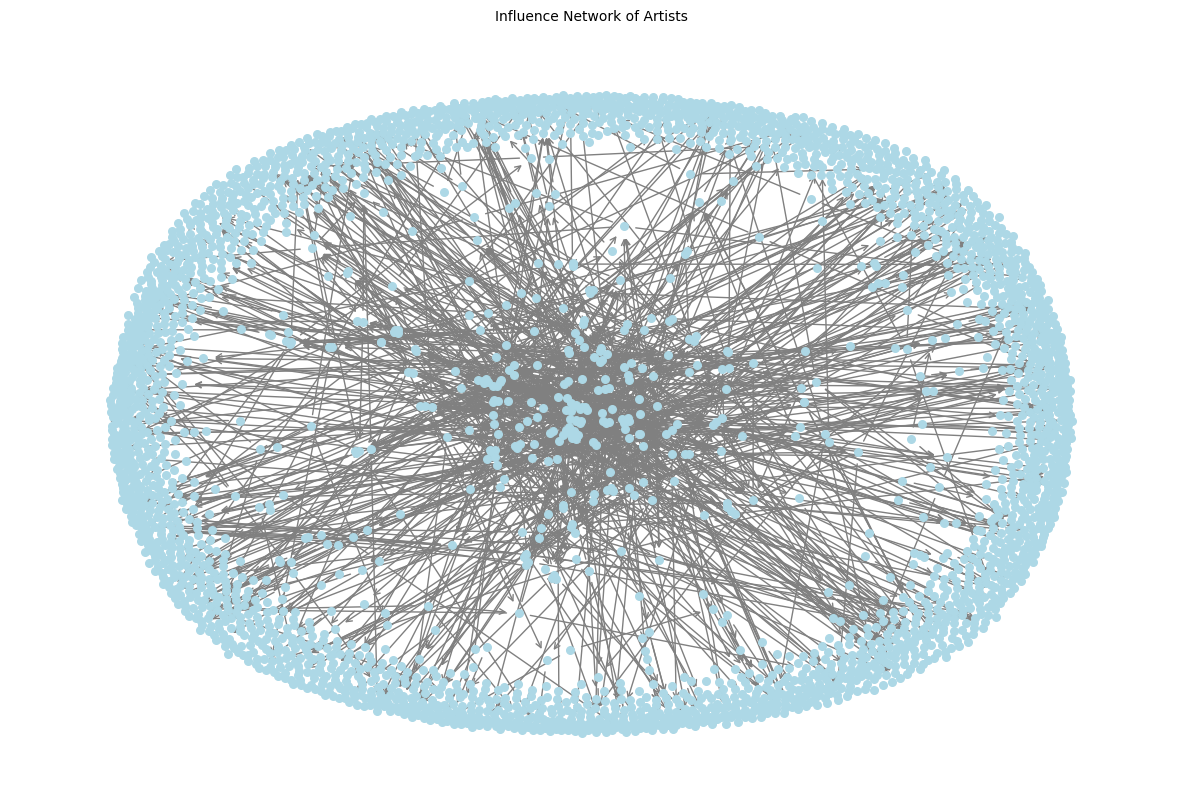

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# Load the final processed CSV file
merged_final_df = pd.read_csv('merged_final.csv')

# Initialize lists for nodes and edges
nodes = []
edges = []
node_attributes = {}  # Dictionary to store attributes for each node

# Populate nodes, edges, and attributes based on the DataFrame
for _, row in merged_final_df.iterrows():
    artist_url = row['artistUrl']

    # Add the node for the artist URL with attributes
    if artist_url not in nodes:  # Avoid duplicates
        nodes.append(artist_url)
        # Store attributes for this node
        node_attributes[artist_url] = {
            'friends': row['friends'],
            'movements': row['movements'],
            'type': row['type'],
            'nation': row['nation'],
            'institution_name': row['institution_name']
        }

    # Edge from influenced_by to artistUrl
    if pd.notna(row['influenced_by']):
        influenced_by_urls = [influence.strip() for influence in row['influenced_by'].split(',')]
        for influenced_by_url in influenced_by_urls:
            edges.append((influenced_by_url, artist_url))  # Create a directed edge

    # Edge from artistUrl to influenced_on
    if pd.notna(row['influenced_on']):
        influenced_on_urls = [influence.strip() for influence in row['influenced_on'].split(',')]
        for influenced_on_url in influenced_on_urls:
            edges.append((artist_url, influenced_on_url))  # Create a directed edge

# Create the graph
G = nx.DiGraph()  # Use DiGraph for directed edges
G.add_nodes_from(nodes)  # Add all nodes
G.add_edges_from(edges)  # Add all edges

# Add attributes to each node
for node, attributes in node_attributes.items():
    G.nodes[node].update(attributes)

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)  # Layout for the graph

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=30, node_color='lightblue')

# Draw edges
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color='gray')

# Title for the plot
plt.title("Influence Network of Artists")
plt.axis('off')  # Turn off the axis
plt.show()

# # Print nodes and their attributes
# print("Nodes with attributes:")
# for node in nodes:
#     print(f"{node}: {G.nodes[node]}")


**GOAL 1**

In [ ]:
# Calculate various centrality measures
centrality_measures = {
    'Out-Degree Centrality': nx.out_degree_centrality(G),
    # 'Betweenness Centrality': nx.betweenness_centrality(G),
    # 'Closeness Centrality': nx.closeness_centrality(G),
    'Eigenvector Centrality': nx.eigenvector_centrality(G, max_iter=1000)  # Increase max_iter if needed
}

# Display the top 10 artists for each centrality measure
for measure, centrality in centrality_measures.items():
    sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 Artists by {measure}:")
    for artist, score in sorted_centrality:
        print(f"{artist}: {score:.4f}")



Top 10 Artists by Out-Degree Centrality:
pablo-picasso: 0.0080
paul-cezanne: 0.0073
rembrandt: 0.0067
caravaggio: 0.0067
titian: 0.0054
gustave-courbet: 0.0054
nicolas-poussin: 0.0051
diego-velazquez: 0.0051
raphael: 0.0048
henri-matisse: 0.0048

Top 10 Artists by Eigenvector Centrality:
damien-hirst: 0.3978
michel-majerus: 0.2962
banksy: 0.2505
young-british-artists: 0.2504
tracey-emin: 0.2504
anish-kapoor: 0.2504
wolfgang-tillmans: 0.2108
jessica-stockholder: 0.2048
neo-expressionism: 0.1981
andy-warhol: 0.1839


**GOAL 2**

**2nd Goal**
Key Concepts

1st method:

Out-Degree Centrality: Measures how influential a node (artist) is based on its outgoing connections. In this context, out-degree centrality counts the number of artists each artist has influenced, indicating their overall influence in the network.
Aggregation by Movement: To determine the most influential movements, we average the out-degree centrality of all artists associated with each movement. Higher average centrality for a movement means its artists are more influential.

Top 10 Most Influential Movements:
                                  movements  out_degree_centrality
31                               Coptic art               0.002072
21                            Byzantine Art               0.001753
65                               Indigenism               0.001009
0    1st Intermediate Period (2181–2055 BC)               0.000956
40   Early Dynastic Period (3150 – 2686 BC)               0.000956
110              New Kingdom (1550–1069 BC)               0.000956
138            Ptolemaic Period (332–30 BC)               0.000956
118              Old Kingdom (2686–2181 BC)               0.000956
1    2nd Intermediate Period (1650–1550 BC)               0.000956
8            Amarna Period (1351 - 1334 BC)               0.000956


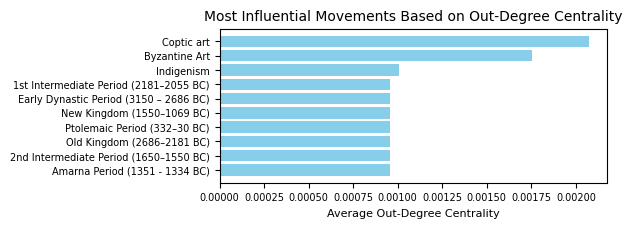

In [ ]:
# Calculate Out-Degree Centrality for each artist
out_degree_centrality = nx.out_degree_centrality(G)

# Create a DataFrame to summarize out-degree centrality measures with movements
centrality_df = pd.DataFrame({
    'artistUrl': list(out_degree_centrality.keys()),
    'out_degree_centrality': list(out_degree_centrality.values())
})

# Merge centrality scores with the original DataFrame to include movements
centrality_df = centrality_df.merge(merged_final_df[['artistUrl', 'movements']], on='artistUrl', how='left')

# Split multiple movements and expand rows so each movement is on a separate row
centrality_df['movements'] = centrality_df['movements'].str.split(',')
expanded_centrality_df = centrality_df.explode('movements')

# Clean up whitespace in movements column
expanded_centrality_df['movements'] = expanded_centrality_df['movements'].str.strip()

# Group by movements to calculate the average out-degree centrality for each movement
movement_centrality = expanded_centrality_df.groupby('movements')['out_degree_centrality'].mean().reset_index()

# Sort movements by average out-degree centrality to find the most influential
movement_centrality = movement_centrality.sort_values(by='out_degree_centrality', ascending=False)

# Print the top 10 most influential movements based on out-degree centrality
print("Top 10 Most Influential Movements:")
print(movement_centrality.head(10))

# Optional: Visualize the top 10 influential movements
plt.figure(figsize=(5, 2))
plt.barh(movement_centrality['movements'].head(10), movement_centrality['out_degree_centrality'].head(10), color='skyblue')
plt.xlabel('Average Out-Degree Centrality')
plt.title('Most Influential Movements Based on Out-Degree Centrality')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


2nd Method

create a graph where movements are the nodes and directed edges represent the influence that each movement has over artists. In this new graph:

Each movement becomes a node.
A directed edge points from a movement node to an artist (from artistUrl) to show that the movement influenced that artist.

After building this graph, we can calculate out-degree centrality for each movement to measure how many artists it has influenced. Finally, we can plot the graph for visualization.

Top 10 Most Influential Movements Based on Out-Degree Centrality (Movement-Artist Graph):
                   Movement  Out-Degree Centrality
36              Romanticism               0.081098
42            Impressionism               0.066731
64            Expressionism               0.064176
37                  Realism               0.061303
90   Abstract Expressionism               0.048851
80               Surrealism               0.048531
34                  Baroque               0.046296
68             Abstract Art               0.045658
53       Post-Impressionism               0.041507
135            Contemporary               0.034802


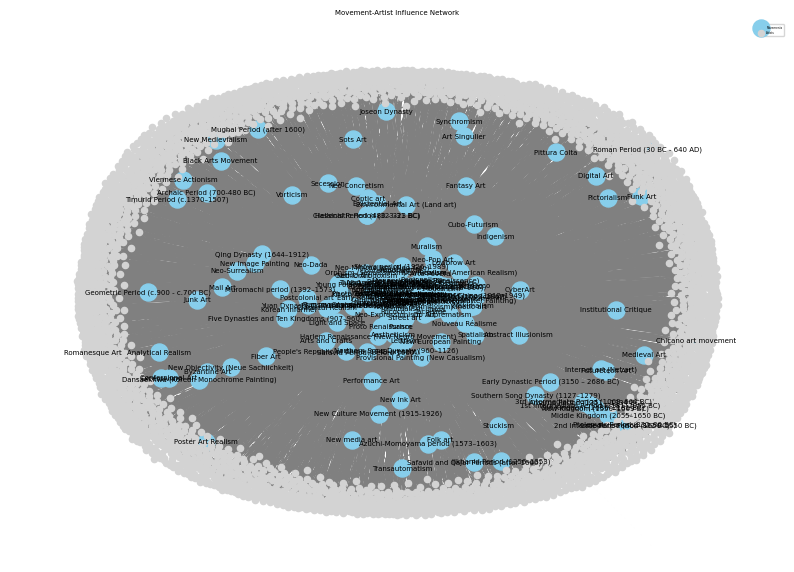

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the final processed CSV file
merged_final_df = pd.read_csv('merged_final.csv')

# Initialize a new directed graph for movements influencing artists
movement_artist_graph = nx.DiGraph()

# Populate the graph with movements as nodes influencing artists
for _, row in merged_final_df.iterrows():
    artist_url = row['artistUrl']
    movements = row['movements']

    if pd.notna(movements):
        # Split movements if there are multiple movements in one cell
        movement_list = [movement.strip() for movement in movements.split(',')]

        # Add edges from each movement to the artist
        for movement in movement_list:
            # Add nodes for movements and the artist
            movement_artist_graph.add_node(movement, type='movement')
            movement_artist_graph.add_node(artist_url, type='artist')

            # Add a directed edge from the movement to the artist
            movement_artist_graph.add_edge(movement, artist_url)

# Calculate Out-Degree Centrality for each movement
movement_out_degree_centrality = {node: centrality for node, centrality in nx.out_degree_centrality(movement_artist_graph).items() if movement_artist_graph.nodes[node]['type'] == 'movement'}

# Convert to DataFrame for easier analysis
movement_centrality_df = pd.DataFrame(list(movement_out_degree_centrality.items()), columns=['Movement', 'Out-Degree Centrality'])
movement_centrality_df = movement_centrality_df.sort_values(by='Out-Degree Centrality', ascending=False)

# Print the top 10 most influential movements
print("Top 10 Most Influential Movements Based on Out-Degree Centrality (Movement-Artist Graph):")
print(movement_centrality_df.head(10))

# Plot the movement-artist influence graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(movement_artist_graph, seed=42)  # Position layout for the graph

# Draw movements as smaller nodes and artists as even smaller nodes
movements = [node for node, attr in movement_artist_graph.nodes(data=True) if attr['type'] == 'movement']
artists = [node for node, attr in movement_artist_graph.nodes(data=True) if attr['type'] == 'artist']

nx.draw_networkx_nodes(movement_artist_graph, pos, nodelist=movements, node_size=150, node_color='skyblue', label='Movements')
nx.draw_networkx_nodes(movement_artist_graph, pos, nodelist=artists, node_size=20, node_color='lightgray', label='Artists')

# Draw edges from movements to artists
nx.draw_networkx_edges(movement_artist_graph, pos, edgelist=movement_artist_graph.edges(), arrowstyle='->', arrowsize=6, edge_color='gray')

# Add labels for movements only, with smaller font size
movement_labels = {node: node for node in movements}
nx.draw_networkx_labels(movement_artist_graph, pos, labels=movement_labels, font_size=5)  # Smaller font size for labels

# Title and legend with smaller fonts
plt.title("Movement-Artist Influence Network", fontsize=5)
plt.legend(scatterpoints=1, fontsize=2)
plt.axis('off')
plt.show()


For Goal 3 ("Which were the most influential institutions?"), we can approach it similarly to how we analyzed influential movements:

1st method

Set Up the Graph: We’ll create a graph where institutions are nodes and directed edges represent the influence each institution has on artists.
Calculate Out-Degree Centrality: This measure will help us quantify how many artists are influenced by each institution, thus indicating the institution's influence.
Aggregate and Analyze: We’ll sort the institutions by their out-degree centrality to identify the most influential ones.

In this case:

Each institution will be a node.
An edge from an institution to an artist will indicate that the institution influenced the artist.

Steps to Implement

Initialize a Directed Graph where each institution is a node.
Add Nodes for Institutions: Each unique institution name becomes a node.
Add Nodes and Edges for Artists: For each artist, add an edge from the institution they were associated with to the artist. This association is typically based on the institution_name column.
Calculate Out-Degree Centrality for each institution to measure its influence over artists.
Sort and Display: Identify the top institutions by their out-degree centrality scores.

Top 10 Most Influential Institutions Based on Out-Degree Centrality:
                                          Institution  Out-Degree Centrality
4                                École des Beaux-Arts               0.094545
0                                 Guild of Saint Luke               0.054545
3                            Imperial Academy of Arts               0.049091
13                         Royal Academy of Arts (RA)               0.045455
23                                    Académie Julian               0.034545
33                    Art Students League of New York               0.032727
39   National Academy of Visual Arts and Architecture               0.030909
1                                         Self-taught               0.030909
11                           Kunstakademie Düsseldorf               0.029091
8   Akademie der Bildenden Künste München (Munich ...               0.027273


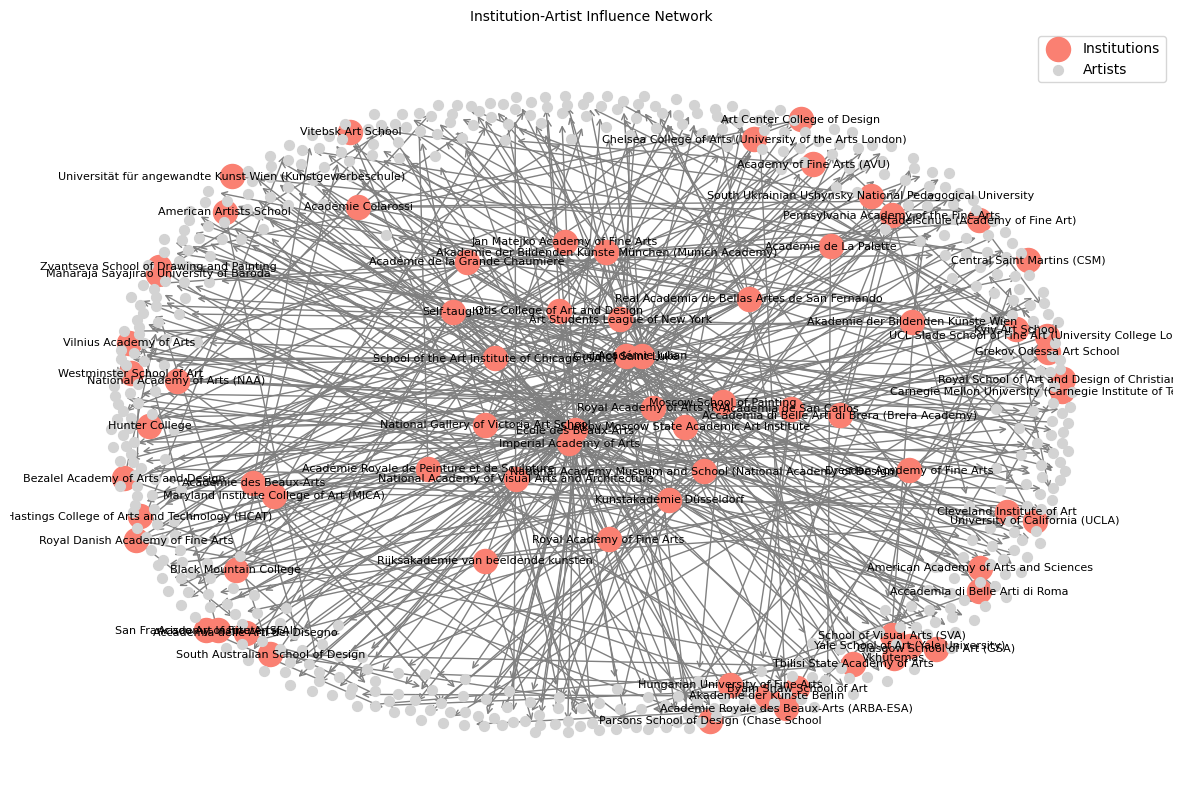

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the final processed CSV file
merged_final_df = pd.read_csv('merged_final.csv')

# Initialize a new directed graph for institutions influencing artists
institution_artist_graph = nx.DiGraph()

# Populate the graph with institutions as nodes influencing artists
for _, row in merged_final_df.iterrows():
    artist_url = row['artistUrl']
    institution_name = row['institution_name']

    if pd.notna(institution_name):
        # Add nodes for institutions and the artist
        institution_artist_graph.add_node(institution_name, type='institution')
        institution_artist_graph.add_node(artist_url, type='artist')

        # Add a directed edge from the institution to the artist
        institution_artist_graph.add_edge(institution_name, artist_url)

# Calculate Out-Degree Centrality for each institution
institution_out_degree_centrality = {node: centrality for node, centrality in nx.out_degree_centrality(institution_artist_graph).items() if institution_artist_graph.nodes[node]['type'] == 'institution'}

# Convert to DataFrame for easier analysis
institution_centrality_df = pd.DataFrame(list(institution_out_degree_centrality.items()), columns=['Institution', 'Out-Degree Centrality'])
institution_centrality_df = institution_centrality_df.sort_values(by='Out-Degree Centrality', ascending=False)

# Print the top 10 most influential institutions
print("Top 10 Most Influential Institutions Based on Out-Degree Centrality:")
print(institution_centrality_df.head(10))

# Plot the institution-artist influence graph with improved readability
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(institution_artist_graph, seed=42, k=0.9)  # Adjust 'k' for better node spacing

# Draw institutions as larger nodes and artists as smaller nodes
institutions = [node for node, attr in institution_artist_graph.nodes(data=True) if attr['type'] == 'institution']
artists = [node for node, attr in institution_artist_graph.nodes(data=True) if attr['type'] == 'artist']

nx.draw_networkx_nodes(institution_artist_graph, pos, nodelist=institutions, node_size=300, node_color='salmon', label='Institutions')
nx.draw_networkx_nodes(institution_artist_graph, pos, nodelist=artists, node_size=50, node_color='lightgray', label='Artists')

# Draw edges from institutions to artists
nx.draw_networkx_edges(institution_artist_graph, pos, edgelist=institution_artist_graph.edges(), arrowstyle='->', arrowsize=10, edge_color='gray')

# Add labels for institutions only with smaller font size
institution_labels = {node: node for node in institutions}
nx.draw_networkx_labels(institution_artist_graph, pos, labels=institution_labels, font_size=8)  # Smaller font size

# Title and legend
plt.title("Institution-Artist Influence Network")
plt.legend(scatterpoints=1)
plt.axis('off')
plt.show()



**2nd method**

Closeness Centrality: Calculates the average shortest path distance from an institution to all other nodes, indicating how easily information can spread from this institution. Higher closeness centrality means the institution is more "central" and can influence others more directly.

igenvector Centrality: A recursive measure that considers an institution influential if it is connected to other highly influential nodes. Institutions connected to many other influential artists or institutions will have higher scores. Note that this measure can take more computation time, especially for large networks.

Visualization: The graph plot shows institutions as larger nodes and artists as smaller nodes, with edges undirected. Institution nodes are built on top of the first main graph of this assignment, so it is directly connected to a few nodes, and via those nodes it can be connected to other nodes.

Top Institutions by Closeness Centrality: These institutions can reach other nodes in the network more efficiently, suggesting they have a central position in the undirected network.
Top Institutions by Eigenvector Centrality: These are institutions connected to other influential nodes, indicating they are embedded in influential parts of the network.

Top 10 Most Influential Institutions by Closeness Centrality (Undirected):
                                          Institution  Closeness Centrality
4                                École des Beaux-Arts              0.084119
15      Real Academia de Bellas Artes de San Fernando              0.080804
0                                 Guild of Saint Luke              0.076027
18                                 Académie Colarossi              0.075552
13                         Royal Academy of Arts (RA)              0.075049
8   Akademie der Bildenden Künste München (Munich ...              0.074816
33                    Art Students League of New York              0.074520
7                          Royal Academy of Fine Arts              0.074487
1                                         Self-taught              0.072960
23                                    Académie Julian              0.072694

Top 10 Most Influential Institutions by Eigenvector Centrality (Undirected):
           

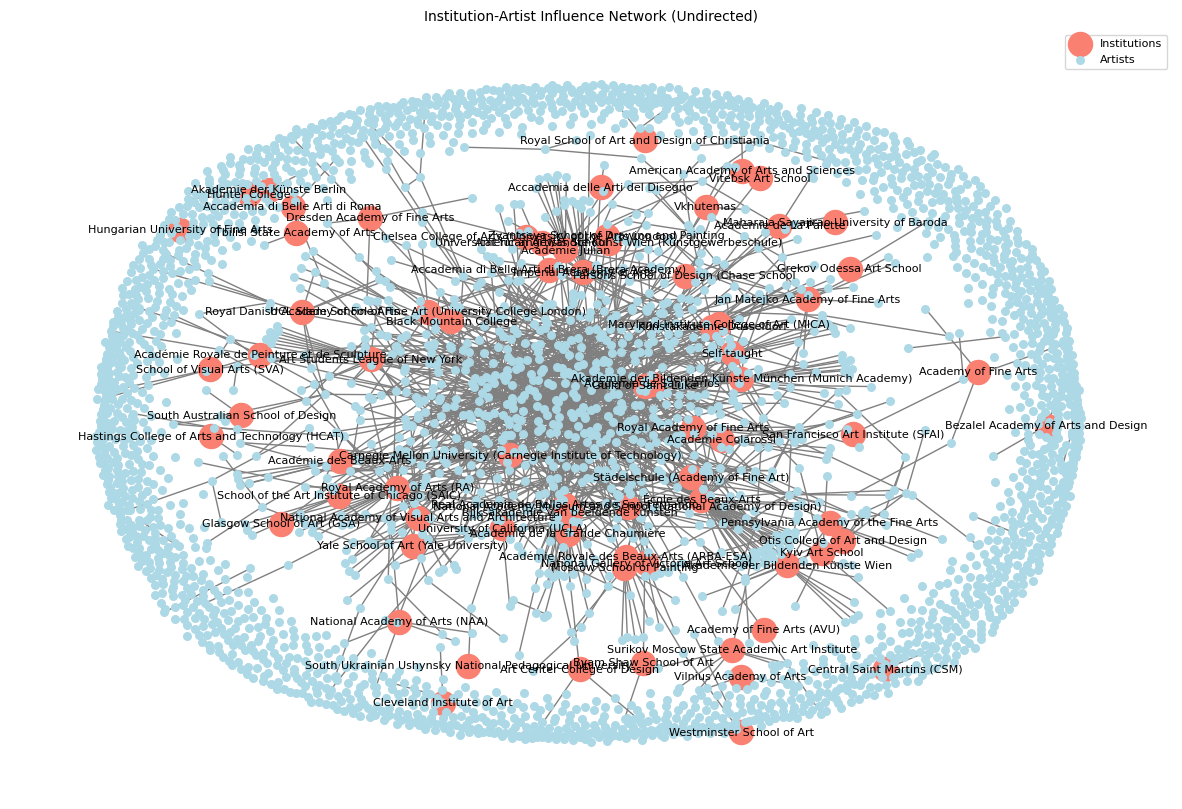

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the final processed CSV file
merged_final_df = pd.read_csv('merged_final.csv')

# Initialize a directed graph
G = nx.DiGraph()

# Populate the graph with nodes and edges
for _, row in merged_final_df.iterrows():
    artist_url = row['artistUrl']
    institution_name = row['institution_name']

    # Add the artist node with attributes
    G.add_node(artist_url, type='artist', friends=row['friends'], movements=row['movements'],
               nation=row['nation'], institution_name=institution_name)

    # Add the institution node (if it exists) and connect it to the artist
    if pd.notna(institution_name):
        G.add_node(institution_name, type='institution')
        G.add_edge(institution_name, artist_url)  # Directed edge from institution to artist

    # Add edges based on 'influenced_by' and 'influenced_on'
    if pd.notna(row['influenced_by']):
        influenced_by_urls = [influence.strip() for influence in row['influenced_by'].split(',')]
        for influenced_by_url in influenced_by_urls:
            G.add_edge(influenced_by_url, artist_url)

    if pd.notna(row['influenced_on']):
        influenced_on_urls = [influence.strip() for influence in row['influenced_on'].split(',')]
        for influenced_on_url in influenced_on_urls:
            G.add_edge(artist_url, influenced_on_url)

# Convert to undirected graph for centrality calculations
G_undirected = G.to_undirected()

# Calculate Closeness Centrality for each institution
institution_closeness_centrality = {
    node: centrality for node, centrality in nx.closeness_centrality(G_undirected).items()
    if G_undirected.nodes[node].get('type') == 'institution'
}

# Calculate Eigenvector Centrality for each institution
institution_eigenvector_centrality = {
    node: centrality for node, centrality in nx.eigenvector_centrality(G_undirected, max_iter=1000).items()
    if G_undirected.nodes[node].get('type') == 'institution'
}

# Convert to DataFrames for easier analysis
closeness_df = pd.DataFrame(list(institution_closeness_centrality.items()), columns=['Institution', 'Closeness Centrality'])
eigenvector_df = pd.DataFrame(list(institution_eigenvector_centrality.items()), columns=['Institution', 'Eigenvector Centrality'])

# Sort and display top institutions for each centrality measure
print("Top 10 Most Influential Institutions by Closeness Centrality (Undirected):")
print(closeness_df.sort_values(by='Closeness Centrality', ascending=False).head(10))

print("\nTop 10 Most Influential Institutions by Eigenvector Centrality (Undirected):")
print(eigenvector_df.sort_values(by='Eigenvector Centrality', ascending=False).head(10))

# Plot the graph with institutions and artists
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_undirected, seed=42, k=0.1)  # Layout for better distribution

# Define nodes by type for distinct styling
institutions = [node for node, attr in G_undirected.nodes(data=True) if attr.get('type') == 'institution']
artists = [node for node, attr in G_undirected.nodes(data=True) if attr.get('type') != 'institution']

# Draw nodes: larger for institutions, smaller for artists
nx.draw_networkx_nodes(G_undirected, pos, nodelist=institutions, node_size=300, node_color='salmon', label='Institutions')
nx.draw_networkx_nodes(G_undirected, pos, nodelist=artists, node_size=30, node_color='lightblue', label='Artists')

# Draw edges with gray color
nx.draw_networkx_edges(G_undirected, pos, edgelist=G_undirected.edges(), edge_color='gray')

# Add labels for institutions only with smaller font size
institution_labels = {node: node for node in institutions}
nx.draw_networkx_labels(G_undirected, pos, labels=institution_labels, font_size=8)

# Title and legend
plt.title("Institution-Artist Influence Network (Undirected)", fontsize=10)
plt.legend(scatterpoints=1, fontsize=8)
plt.axis('off')
plt.show()


**GOAL 4**-Which nationalities concentrate the majority of artists?

1st method

Top Nationalities by Out-Degree (Number of Associated Artists):
   Nationality  Out-Degree Centrality
28    American               0.169436
11      French               0.130987
4      Italian               0.087651
17     British               0.081134
13      German               0.052134
25     Russian               0.035191
14       Dutch               0.034213
16     Spanish               0.028348
30    Romanian               0.025415
12    Japanese               0.021831


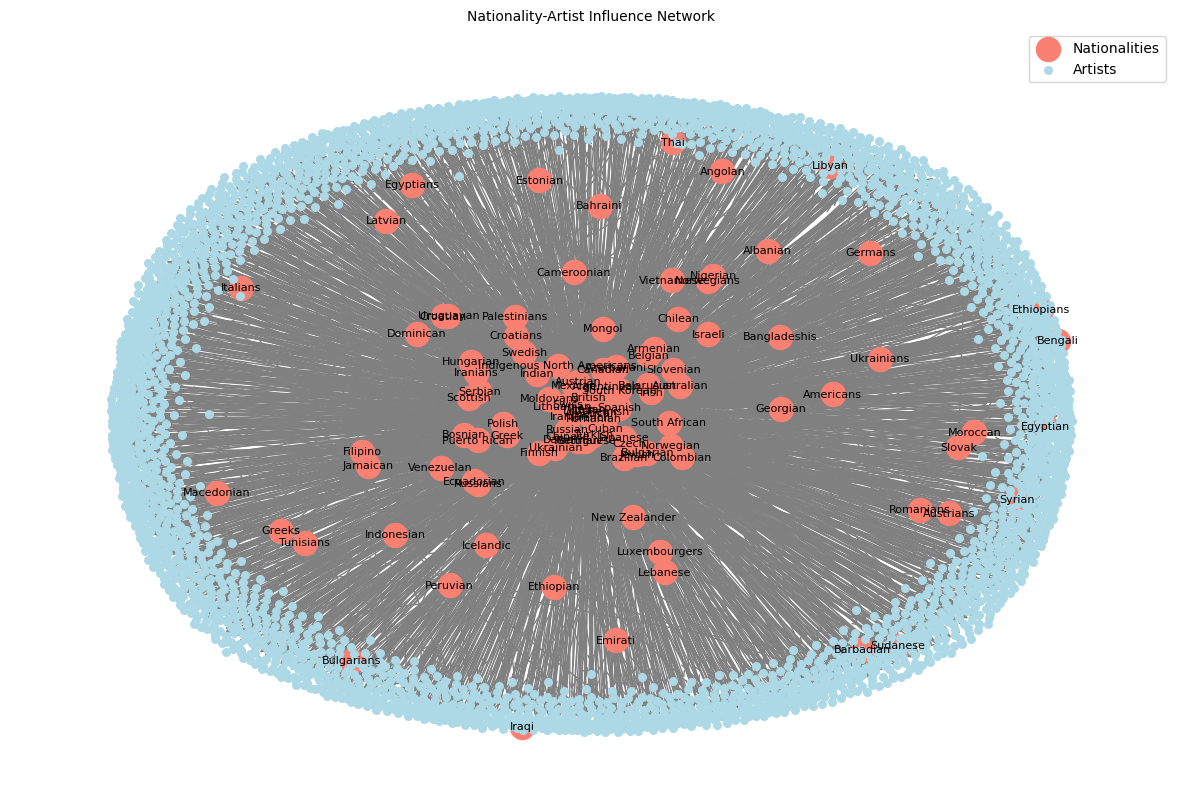

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a new directed graph for nationalities influencing artists
nationality_artist_graph = nx.DiGraph()

# Add nodes and directed edges from nationalities to associated artists
for _, row in merged_final_df.iterrows():
    artist_url = row['artistUrl']
    nationality = row['nation']

    if pd.notna(nationality):
        # Add nationality node if not already in the graph
        if nationality not in nationality_artist_graph:
            nationality_artist_graph.add_node(nationality, type='nationality')

        # Add artist node if not already in the graph
        if artist_url not in nationality_artist_graph:
            nationality_artist_graph.add_node(artist_url, type='artist')

        # Add directed edge from nationality to artist
        nationality_artist_graph.add_edge(nationality, artist_url)

# Calculate Out-Degree Centrality for each nationality node
out_degree_centrality = {
    node: centrality for node, centrality in nx.out_degree_centrality(nationality_artist_graph).items()
    if nationality_artist_graph.nodes[node].get('type') == 'nationality'
}

# Convert to DataFrame for easier analysis
out_degree_df = pd.DataFrame(list(out_degree_centrality.items()), columns=['Nationality', 'Out-Degree Centrality'])
out_degree_df = out_degree_df.sort_values(by='Out-Degree Centrality', ascending=False)

# Display top nationalities by out-degree centrality
print("Top Nationalities by Out-Degree (Number of Associated Artists):")
print(out_degree_df.head(10))

# Optional: Plot the nationality-artist influence graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(nationality_artist_graph, seed=42, k=0.15)  # Layout for better distribution

# Draw nationality nodes as larger nodes and artists as smaller nodes
nationalities = [node for node, attr in nationality_artist_graph.nodes(data=True) if attr.get('type') == 'nationality']
artists = [node for node, attr in nationality_artist_graph.nodes(data=True) if attr.get('type') == 'artist']

nx.draw_networkx_nodes(nationality_artist_graph, pos, nodelist=nationalities, node_size=300, node_color='salmon', label='Nationalities')
nx.draw_networkx_nodes(nationality_artist_graph, pos, nodelist=artists, node_size=30, node_color='lightblue', label='Artists')

# Draw edges from nationalities to artists
nx.draw_networkx_edges(nationality_artist_graph, pos, edgelist=nationality_artist_graph.edges(), arrowstyle='->', arrowsize=10, edge_color='gray')

# Add labels for nationalities only with smaller font size
nationality_labels = {node: node for node in nationalities}
nx.draw_networkx_labels(nationality_artist_graph, pos, labels=nationality_labels, font_size=8)

# Title and legend
plt.title("Nationality-Artist Influence Network")
plt.legend(scatterpoints=1)
plt.axis('off')
plt.show()


**2nd Method**

In [ ]:
import pandas as pd

# Extract the out-degree for each nationality node
out_degrees = {node: nationality_artist_graph.out_degree(node) for node, data in nationality_artist_graph.nodes(data=True) if data.get('type') == 'nationality'}

# Convert to DataFrame for easier sorting and display
out_degree_df = pd.DataFrame(list(out_degrees.items()), columns=['Nationality', 'Artist Count'])

# Sort by artist count in descending order to find the top 10 nationalities
top_nationalities = out_degree_df.sort_values(by='Artist Count', ascending=False).head(10)

# Display the top 10 nationalities with the most associated artists
print("Top 10 Nationalities by Number of Associated Artists:")
print(top_nationalities)


Top 10 Nationalities by Number of Associated Artists:
   Nationality  Artist Count
28    American           520
11      French           402
4      Italian           269
17     British           249
13      German           160
25     Russian           108
14       Dutch           105
16     Spanish            87
30    Romanian            78
12    Japanese            67


In [ ]:
pip install --upgrade python-louvain


**GOAL 5**

**1st method**
Louvain Method: To optimize modularity
and identify communities with high internal
connectedness, the Louvain method was
applied. A distinct ID was given to each
identified community and thereafter linked to
every node in that community. This technique
gives a high-level picture of the topology of
the network and is good at finding highly
connected clusters.

Top 10 Largest Communities in the Network:
   Community ID  Size
0            19   195
1            22   100
2            26    87
3            42    82
4             6    77
5            43    73
6             0    65
7            32    64
8            29    55
9            24    42


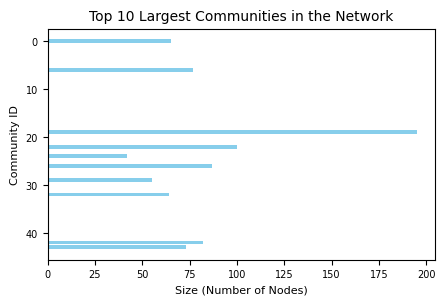

In [ ]:
import community.community_louvain as community_louvain  # Ensure python-louvain is correctly imported
import pandas as pd
import matplotlib.pyplot as plt

# Convert the directed graph to undirected for community detection
G_undirected = G.to_undirected()

# Perform community detection using the Louvain method
partition = community_louvain.best_partition(G_undirected)

# Add community information to each node in the graph
for node, community_id in partition.items():
    G_undirected.nodes[node]['community'] = community_id

# Count the size of each community
community_sizes = pd.Series(list(partition.values())).value_counts().reset_index()
community_sizes.columns = ['Community ID', 'Size']

# Sort by size to find the largest communities
largest_communities = community_sizes.sort_values(by='Size', ascending=False).head(10)

# Display the top 10 largest communities
print("Top 10 Largest Communities in the Network:")
print(largest_communities)

# Optional: Visualize the size distribution of the largest communities
plt.figure(figsize=(5, 3))
plt.barh(largest_communities['Community ID'], largest_communities['Size'], color='skyblue')
plt.xlabel('Size (Number of Nodes)')
plt.ylabel('Community ID')
plt.title('Top 10 Largest Communities in the Network')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()


**2nd method**
Greedy Modularity Community Detection:
The greedy modularity technique was used as
a substitute. In order to maximize intra-
community edges, this algorithm iteratively
groups nodes into communities while also
optimizing for modularity. Each community's
nodes were assigned a community ID.

In [ ]:
import networkx as nx
from operator import itemgetter

# Assuming G is the undirected graph you have with artists and institutions

# Step 1: Detect communities using greedy modularity
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

# Step 2: Assign community labels to each node
modularity_dict = {}
for i, c in enumerate(communities):  # Loop through the list of communities
    for node in c:  # Assign each node in the community a label
        modularity_dict[node] = i  # Community ID is the index of the community in the list

# Set the community ID as a node attribute in the graph
nx.set_node_attributes(G, modularity_dict, 'modularity')

# Step 3: Analyze communities by eigenvector centrality (or other centrality measures)
# Calculate eigenvector centrality for all nodes
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector')

# Example: Display top nodes by eigenvector centrality for the largest community (community 0)
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]  # Nodes in community 0
class0_eigenvector = {n: G.nodes[n]['eigenvector'] for n in class0}  # Eigenvector centrality for these nodes
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:  # Display top 5 nodes by eigenvector centrality in community 0
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

# Step 4: Filter and display communities with more than a specified number of nodes
for i, c in enumerate(communities):
    if len(c) > 2:  # Only consider communities with more than 2 nodes
        print(f'Class {i}:', list(c))  # Print out the class and its members


Modularity Class 0 Sorted by Eigenvector Centrality:
Name: damien-hirst | Eigenvector Centrality: 0.39781703422293785
Name: michel-majerus | Eigenvector Centrality: 0.2962642654567745
Name: banksy | Eigenvector Centrality: 0.2504037018624091
Name: wolfgang-tillmans | Eigenvector Centrality: 0.2108424347076003
Name: jessica-stockholder | Eigenvector Centrality: 0.20475010895581913
Class 0: ['Maryland Institute College of Art (MICA)', 'henry-arthur-mcardle', 'helen-frankenthaler', 'constantin-brancusi', 'helene-de-beauvoir', 'willem-de-kooning', 'edouard-manet', 'walter-sickert', 'alfred-stieglitz', 'man-ray', 'edgar-degas', 'salvador-dali', 'Städelschule (Academy of Fine Art)', 'laszlo-moholy-nagy', 'nan-goldin', 'deborah-azzopardi', 'vladimir-tretchikoff', 'harry-phelan-gibb', 'sam-francis', 'richard-serra', 'Rijksakademie van beeldende kunsten', 'james-rosenquist', 'barnett-newman', 'pierre-auguste-renoir', 'juan-gris', 'aaron-shikler', 'robert-motherwell', 'jessica-stockholder', 'ars